In [1]:
import numpy as np  
import pandas as pd  

import matplotlib.pyplot as plt  
import seaborn as sns
import matplotlib.gridspec as gridspec 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Load data
df = pd.read_csv("./breast cancer data.csv", header=0)

In [3]:
# Data Cleaning
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

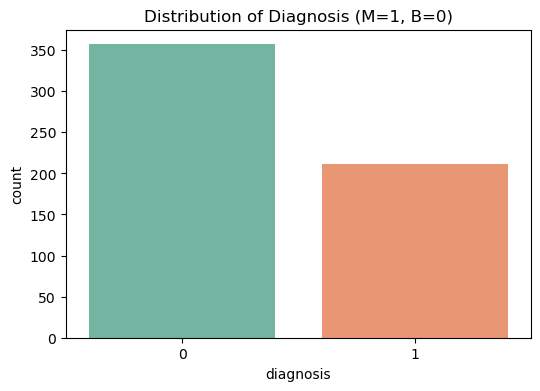

In [4]:
# EDA - Distribution of Classes
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=df, palette='Set2')
plt.title('Distribution of Diagnosis (M=1, B=0)')
plt.show()

C:\Users\sachi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


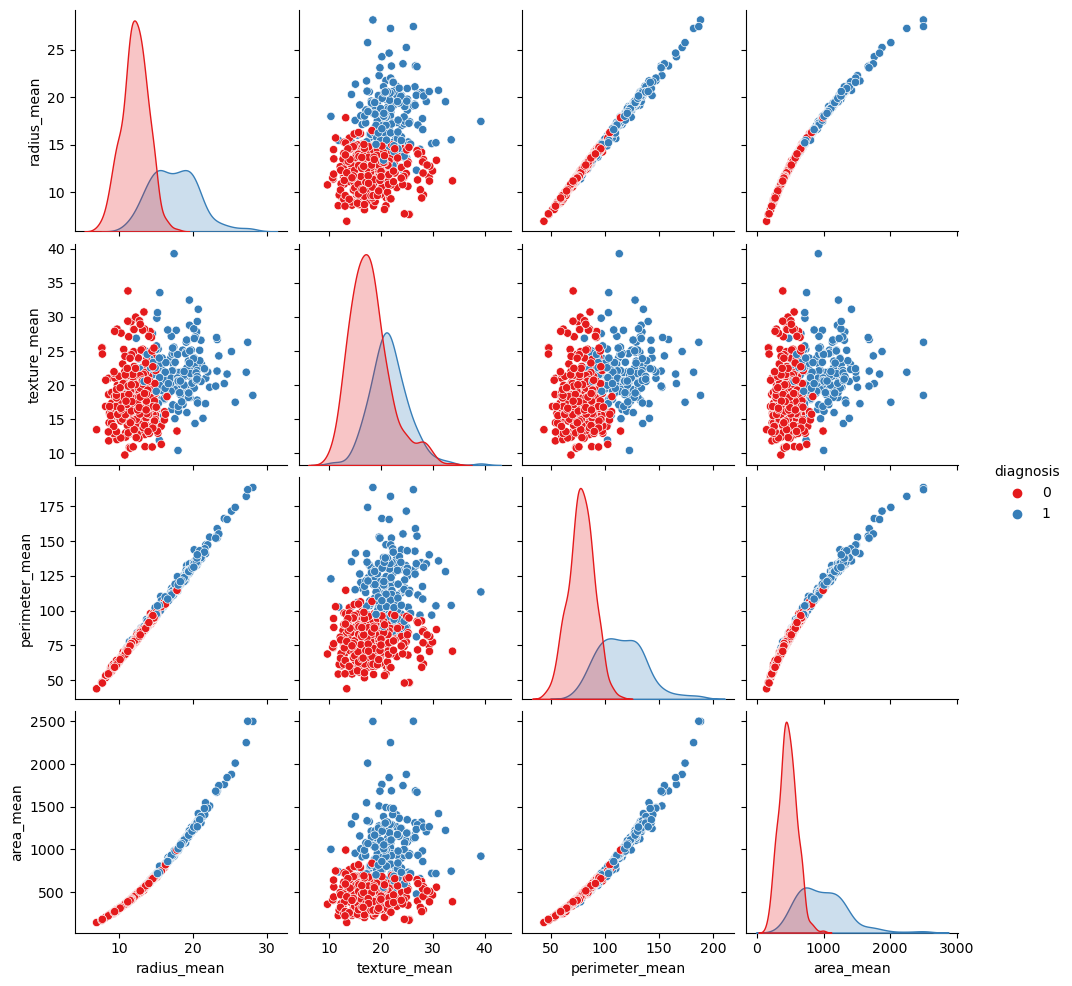

In [5]:
# EDA - Feature Correlations (Pairplot)
sns.pairplot(df, vars=['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean'], hue='diagnosis', palette='Set1')
plt.show()

In [6]:
# Descriptive Statistics
print(df.describe())

        diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720       

In [7]:
# Feature Visualizations (Histograms)
features_mean = list(df.columns[1:11])
dfM = df[df['diagnosis'] == 1]
dfB = df[df['diagnosis'] == 0]

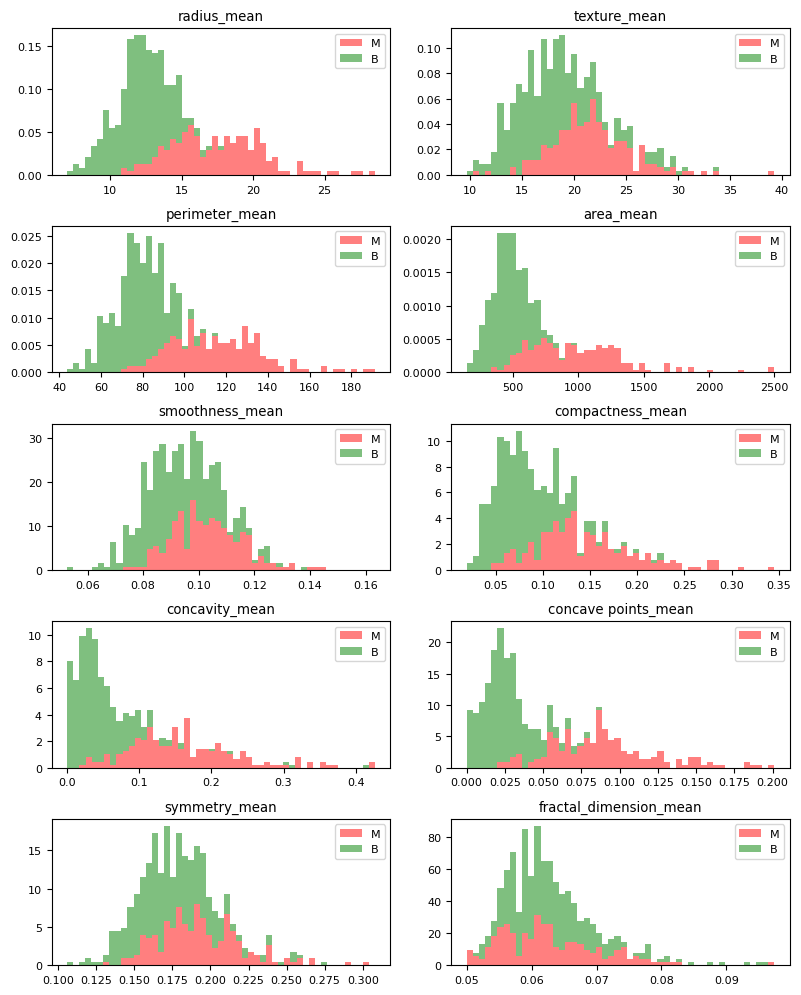

In [8]:
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    binwidth = (max(df[features_mean[idx]]) - min(df[features_mean[idx]])) / 50
    ax.hist([dfM[features_mean[idx]], dfB[features_mean[idx]]], 
            bins=np.arange(min(df[features_mean[idx]]), 
                           max(df[features_mean[idx]]) + binwidth, binwidth), 
            alpha=0.5, stacked=True, density=True, 
            label=['M', 'B'], color=['r', 'g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

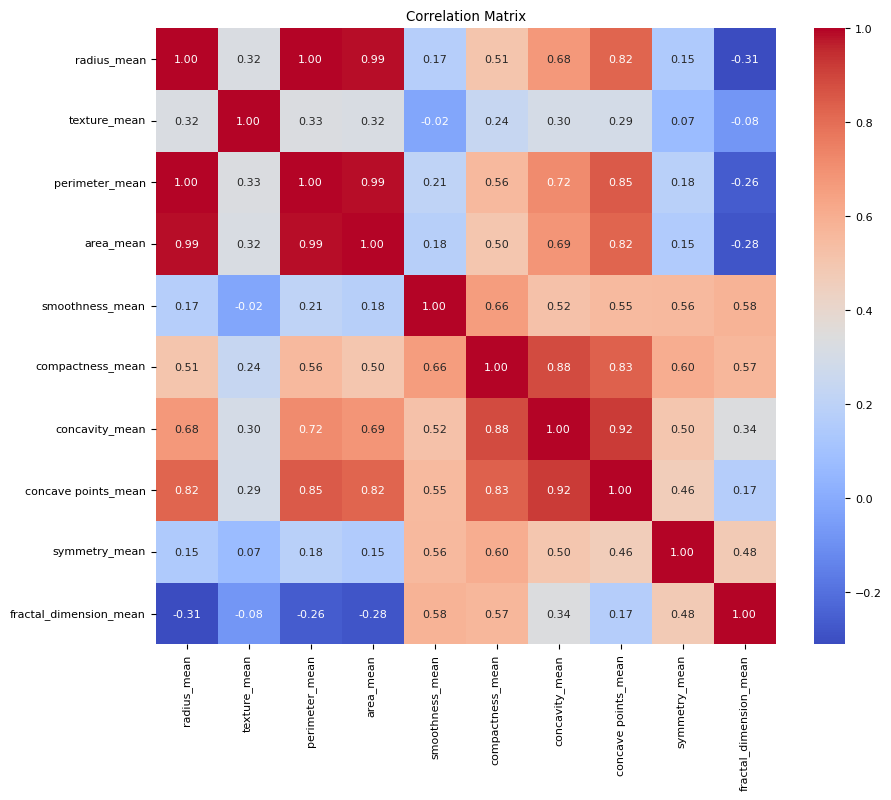

In [9]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df[features_mean].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [10]:
# Train-Test Split
X = df[features_mean]
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
def model_comparison(models, X_train, y_train, X_test, y_test):
    results = []  
    for model in models:
        model.fit(X_train, y_train)
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, model.predict(X_test))
        results.append({'Model': model.__class__.__name__, 
                        'Train Accuracy': train_accuracy, 
                        'Test Accuracy': test_accuracy})
    return pd.DataFrame(results)

In [12]:
# Models to Compare
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier()
]


In [13]:
# Compare models
results = model_comparison(models, X_train, y_train, X_test, y_test)

In [14]:
# Display Results
print(results)

                        Model  Train Accuracy  Test Accuracy
0          LogisticRegression        0.907035       0.935673
1      DecisionTreeClassifier        1.000000       0.900585
2      RandomForestClassifier        1.000000       0.959064
3  GradientBoostingClassifier        1.000000       0.959064


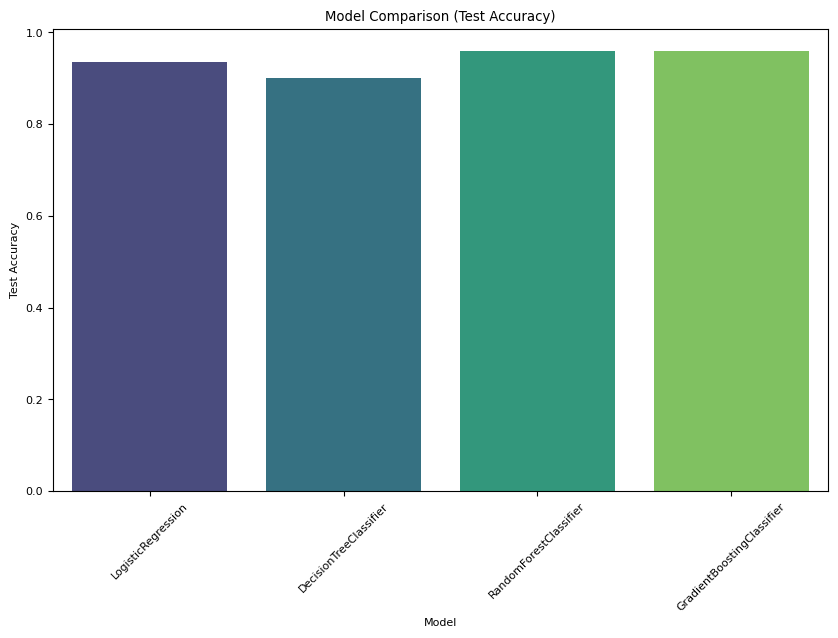

In [15]:
# Visualize Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test Accuracy', data=results, palette='viridis')
plt.title('Model Comparison (Test Accuracy)')
plt.xticks(rotation=45)
plt.show()

In [16]:
def cross_val_comparison(models, X, y):
    cv_results = []  
    for model in models:
        cv_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        cv_results.append({'Model': model.__class__.__name__, 
                           'Cross-Validation Mean Accuracy': np.mean(cv_score)})
    return pd.DataFrame(cv_results)

In [17]:
# Cross-validation results
cv_results = cross_val_comparison(models, X, y)
print(cv_results)

                        Model  Cross-Validation Mean Accuracy
0          LogisticRegression                        0.908632
1      DecisionTreeClassifier                        0.917451
2      RandomForestClassifier                        0.940258
3  GradientBoostingClassifier                        0.947306


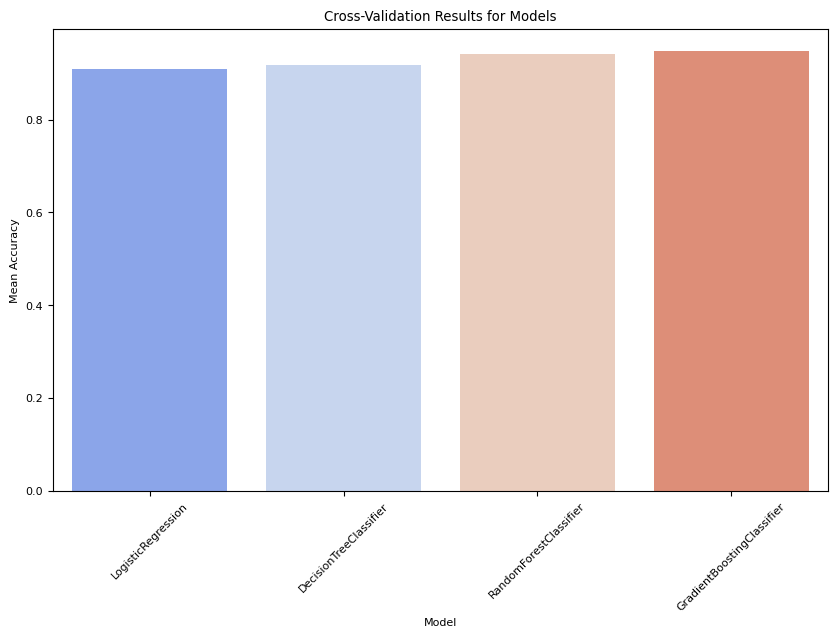

In [18]:
# Visualize Cross-Validation Results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Cross-Validation Mean Accuracy', data=cv_results, palette='coolwarm')
plt.title('Cross-Validation Results for Models')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45)
plt.show()


In [19]:
# Confusion Matrix for Best Model
best_model = GradientBoostingClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

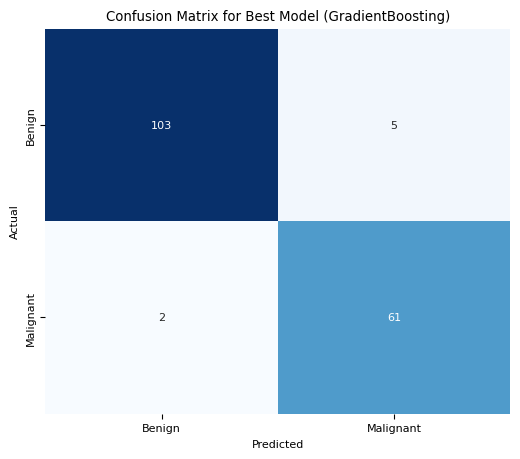

In [20]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix for Best Model (GradientBoosting)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# Classification Report for Best Model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       108
           1       0.92      0.97      0.95        63

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



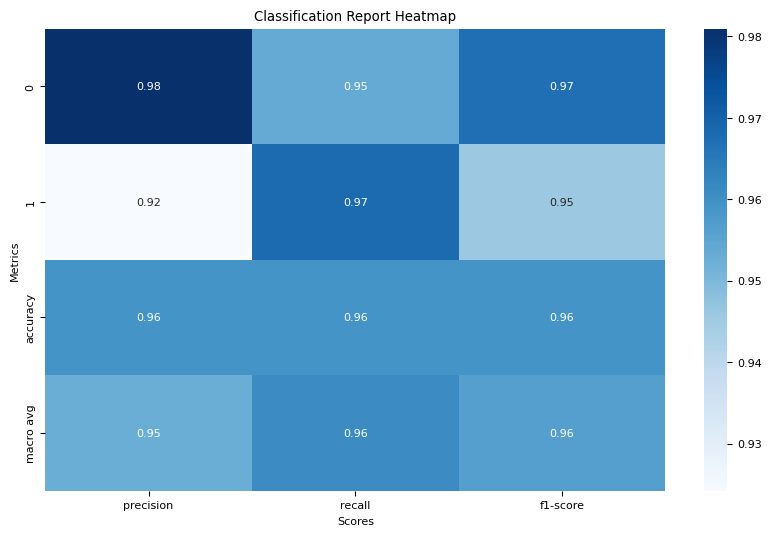

In [22]:
from sklearn.metrics import classification_report
# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Classification Report Heatmap")
plt.ylabel("Metrics")
plt.xlabel("Scores")
plt.show()

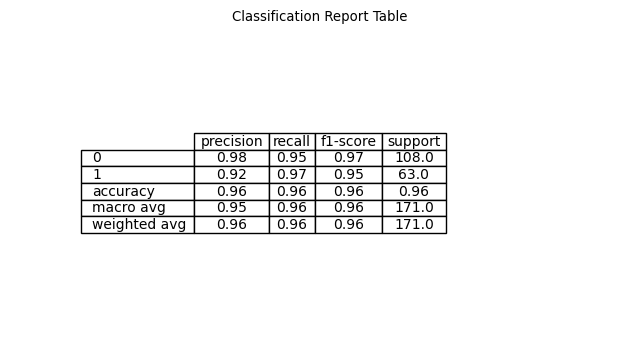

In [23]:
# Convert classification report to a DataFrame for a table view
df_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

# Plot the table
plt.figure(figsize=(8, 4))
plt.axis('off')
table = plt.table(cellText=df_report.round(2).values, 
                  colLabels=df_report.columns, 
                  rowLabels=df_report.index, 
                  loc='center', 
                  cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df_report.columns))))
plt.title("Classification Report Table")
plt.show()
